In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 8.1 MB/s 
     |████████████████████████████████| 1.2 MB 50.7 MB/s 
     |████████████████████████████████| 186 kB 70.4 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 329 kB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [5]:
# get the relative path as the current path
Path.BASE_PATH = path
path

Path('.')

In [6]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [7]:
# check inside the images path
(path/'images').ls()

(#7393) [Path('images/american_pit_bull_terrier_103.jpg'),Path('images/pomeranian_31.jpg'),Path('images/Egyptian_Mau_99.jpg'),Path('images/pug_95.jpg'),Path('images/english_setter_39.jpg'),Path('images/yorkshire_terrier_90.jpg'),Path('images/scottish_terrier_41.jpg'),Path('images/pomeranian_101.jpg'),Path('images/pug_107.jpg'),Path('images/boxer_24.jpg')...]

In [8]:
# use regex to extract a single name from the image
# test this on the first image
img_1 = (path/'images').ls()[0]
img_2 = (path/'images').ls()[4]
img_1.name, img_2.name

('american_pit_bull_terrier_103.jpg', 'english_setter_39.jpg')

In [9]:
# use findall with () around the desired grouping (the pet breed). 
# Then, use _ after the name, followed by 1 or more digits (\d+) followed by a period (\.) followed by jpg. This extracts the desired name from the file name
re.findall("(.+)_\d+\.jpg", img_1.name), re.findall("(.+)_\d+\.jpg", img_2.name)

(['american_pit_bull_terrier'], ['english_setter'])

In [10]:
# now, create a data block using this regex expression
d_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items = get_image_files,
                    splitter = RandomSplitter(seed=8),
                    get_y = using_attr(RegexLabeller("(.+)_\d+\.jpg"), "name"),
                    # use presizing on the data - first resize large then augment this on the gpu
                    item_tfms = Resize(460),
                    batch_tfms = aug_transforms(size=224, min_scale = 0.75))

d_loader = d_block.dataloaders(path/'images')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


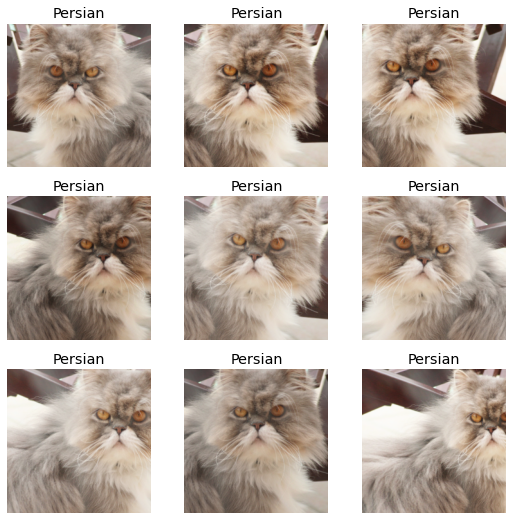

In [11]:
# check that the data block is working well
d_loader.show_batch(unique=True)

In [12]:
# train a simple cnn using fast ai
learn = cnn_learner(d_loader, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.506243,0.337330,0.119080,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.506352,0.263080,0.084574,01:13
1,0.323013,0.182918,0.059540,01:14


## Testing out cross entropy loss

In [13]:
# create a tensor with 3 categories and standard deviation 3
test_tens = torch.randn(12)*3
sample_acts = test_tens.view(-1, 3)
sample_acts


tensor([[-1.3043, -0.1678,  2.0078],
        [ 1.1734,  0.9081, -0.2491],
        [-6.5052,  5.9765,  1.0514],
        [ 1.7796, -0.3575,  5.0854]])

In [14]:
# calculate the softmax of the tensor
softmax_acts = sample_acts.softmax(dim=1)

# take the log of the tensor
log_softmax_acts = softmax_acts.log()

# index using nll_loss
targets = tensor([0, 1, 2, 1])

cross_entropy_loss = -log_softmax_acts[range(sample_acts.shape[0]), targets]
cross_entropy_loss, cross_entropy_loss.mean()

(tensor([3.4519, 0.9625, 4.9323, 5.4831]), tensor(3.7074))

In [15]:
# use cross entropy loss with pytorch
nn.CrossEntropyLoss(reduction='none')(sample_acts, targets), nn.CrossEntropyLoss()(sample_acts, targets)

(tensor([3.4519, 0.9625, 4.9323, 5.4831]), tensor(3.7074))

## Learning rate Finder

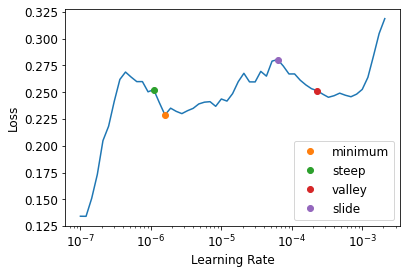

In [16]:
# use leslie smith's learning rate finder method to find the optimal learning rate
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [17]:
lr_min, lr_valley, lr_slide

(1.58489319801447e-07, 0.0002290867705596611, 6.30957365501672e-05)

In [18]:
# choose 3*10^-5 as lr and fine tune for 1 more cycle
learn.fine_tune(1, base_lr=3e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.236887,0.178610,0.056834,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.221375,0.178286,0.054127,01:15


## Freezing and unfreezing

In [19]:
# assume we found optimal lr to be 3e-5, fit the new layer for 3 epochs
learn.fit_one_cycle(3, lr_max=3e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.230446,0.188156,0.062246,01:15
1,0.203759,0.164352,0.054804,01:15
2,0.154622,0.160249,0.057510,01:15


In [20]:
# unfreeze the rest of the model, find new learning rate and fit using discriminative learning rates
# assyme we found optimal lr to be 1e-5. Use discriminative rates in this range to continue the training
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.157283,0.158982,0.055480,01:15
1,0.142145,0.159213,0.054804,01:15
2,0.127613,0.155076,0.052774,01:15
3,0.118651,0.153407,0.053451,01:14
4,0.101281,0.148795,0.050068,01:15
5,0.099346,0.152365,0.050068,01:14
